In [1]:
# Визуализации

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
plt.style.use("bmh")
plt.rcParams["axes.titlesize"] = "large"

In [3]:
# Общеe

import os
import tqdm
import pathlib
import numpy as np
import pandas as pd

tqdm.tqdm.pandas()
pd.set_option('display.max_columns', None)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from catboost import CatBoostRegressor

<div class="alert alert-block alert-warning">
Не забудьте заменить <tt>DATA_DIR</tt> на имя локальной директории, в которую сохранили файл.
</div>

In [5]:
DATA_DIR = pathlib.Path("../data/2/dataset/")
RS = 3984765

In [5]:
DATA_DIR = pathlib.Path("./data")
RS = 42

# Загрузка данных

Данные хранятся в формате Parquet: читается быстрее, места занимает меньше.

In [6]:
train = pd.read_parquet(DATA_DIR.joinpath("train.parquet"))
train.head()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,target0,target1
0,32.910908,17.376350,77.557840,2.929855,gas1,20.487150,57.633085,49.245392,-44.124381,23.400064,-28.640648,-10.995420,40.856313,29.912800,33.168114,18.769718,41.812507,14.203652,9.689942,17.951627,24.198589,102.448710,110.529868,56.817260,12.887802,27.050891,6.502743
1,41.263782,22.419445,47.945514,-25.847472,gas2,21.461239,3.474080,49.659980,-13.553188,-13.047593,-12.445940,16.657368,42.453280,99.792375,127.159321,-13.180244,50.722470,-14.451904,-0.906120,105.724742,-9.435222,-16.060150,37.286110,61.224272,39.822424,84.127890,76.578716
2,25.580283,17.376350,77.654180,2.799411,gas1,20.487150,28.938295,49.245392,-44.124381,20.610679,-28.641150,-1.886830,40.927941,16.340674,60.760647,18.658501,52.731646,14.395054,9.779019,17.951638,24.999453,101.728213,111.471534,52.664304,12.887802,22.080133,3.036043
3,33.756900,17.376350,73.049625,2.953982,gas1,20.487150,28.932311,49.245392,-44.124381,18.107963,-28.642094,16.284415,40.869406,43.707663,48.037510,18.771030,52.305692,14.184314,9.798969,17.951675,23.990300,101.312113,115.589451,56.840719,12.887802,30.234082,8.910795
4,4.223732,38.772534,48.015553,-25.843943,gas2,24.635721,12.011581,51.030938,84.244199,-17.735680,40.395582,16.557978,65.988300,91.081310,150.949700,-13.172169,51.012294,-14.439953,8.262354,90.187207,-2.901661,-16.060150,37.398779,40.488468,128.295838,71.128092,50.475082


В данных есть один категориальный признак: `feature4`. Он может принимать значения `gas1` и `gas2`. Таргета два: `target0` и `target1`.

In [7]:
CAT = ["feature4"]
TARGETS = ["target0", "target1"]
FTS = train.filter(like="feature").columns.difference(CAT)

Проверяем, что с пропусками:

In [8]:
train.isnull().any().mean()

0.0

Их нет! Вот это поворот! Посмотрим на таргеты:

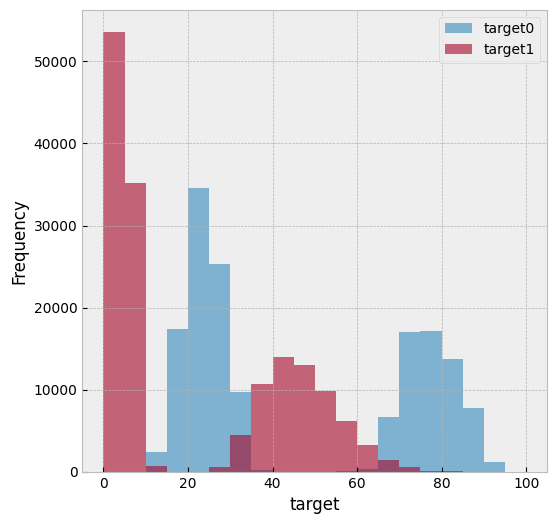

In [9]:
plt.figure(figsize=(6,6))

train[TARGETS].plot(kind="hist", range=(0, 100), bins=20, alpha=0.6, ax=plt.gca())
plt.xlabel("target");

Категориальный признак меняем на числовой:

In [10]:
train["gas"] = 0
train.loc[train.feature4=="gas2", "gas"] = 1

In [11]:
FTS = FTS.union(["gas"])

# Простая модель

Построим простую модель со случайным разбиением на тренировочное и валидационное множества. Таргеты будем моделировать отдельно.

In [12]:
X_tr, X_val, y_tr, y_val = train_test_split(train[FTS], train[TARGETS], train_size=0.5, random_state=RS)

In [27]:
%%time
models = {}
tr_preds = []
val_preds = []

for tg in TARGETS:
    print(f"{tg}", "=" * 10)
    cb_model = CatBoostRegressor(max_depth=4, iterations=5000,
                                 early_stopping_rounds=20, objective="MAPE", verbose=200,
                                 random_state=RS)
    cb_model.fit(X_tr, y_tr[tg], eval_set=(X_val, y_val[tg]))

    tr_preds.append(cb_model.predict(X_tr))
    val_preds.append(cb_model.predict(X_val))

    models[tg] = cb_model

target0 ==========
0:	learn: 0.3849499	test: 0.3882364	best: 0.3882364 (0)	total: 9.09ms	remaining: 45.4s
200:	learn: 0.0651563	test: 0.0653452	best: 0.0653452 (200)	total: 1.61s	remaining: 38.4s
400:	learn: 0.0238987	test: 0.0238584	best: 0.0238584 (400)	total: 3.42s	remaining: 39.2s
600:	learn: 0.0147546	test: 0.0148271	best: 0.0148271 (600)	total: 5.53s	remaining: 40.5s
800:	learn: 0.0120293	test: 0.0121300	best: 0.0121300 (800)	total: 7.1s	remaining: 37.2s
1000:	learn: 0.0103850	test: 0.0104976	best: 0.0104976 (1000)	total: 8.76s	remaining: 35s
1200:	learn: 0.0093929	test: 0.0095225	best: 0.0095225 (1200)	total: 10.8s	remaining: 34.3s
1400:	learn: 0.0086623	test: 0.0088086	best: 0.0088086 (1400)	total: 12.6s	remaining: 32.3s
1600:	learn: 0.0080397	test: 0.0082001	best: 0.0082001 (1600)	total: 14.3s	remaining: 30.3s
1800:	learn: 0.0075825	test: 0.0077523	best: 0.0077523 (1800)	total: 16.2s	remaining: 28.7s
2000:	learn: 0.0072116	test: 0.0073942	best: 0.0073942 (2000)	total: 18.2s	re

Собираем предсказания вместе:

In [28]:
tr_preds = np.column_stack(tr_preds)
val_preds = np.column_stack(val_preds)

In [29]:
tr_preds = np.clip(tr_preds, 0, 100)
val_preds = np.clip(val_preds, 0, 100)

Посчитаем метрики (так они считаются и для загрузок на платформе):

In [30]:
print(f"MAPE (train): {mean_absolute_percentage_error(y_tr, tr_preds) * 100:.3f} %")
print(f"MAPE (val): {mean_absolute_percentage_error(y_val, val_preds) * 100:.3f} %")

MAPE (train): 1.567 %
MAPE (val): 1.633 %


Сохраним модели:

In [31]:
for target, model in models.items():
    model.save_model(DATA_DIR.joinpath(f"{target}-cb-v1.cbm"))

Эти модели (в зависимости от `RS`) должны давать на публичном лидерборде `~10%`. Как сделать так, чтобы локальная валидация сходилась с лидербордом: вот в чем вопрос!